In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from prophet import Prophet

Đã tải mô hình Prophet thành công!
✅ Tải scaler thành công: min=8.382509625943104, max=139.9770257564176
Các quận hiện có trong mô hình: ['Huyện Hòa Vang', 'Quận Cẩm Lệ', 'Quận Hải Châu', 'Quận Liên Chiểu', 'Quận Ngũ Hành Sơn', 'Quận Sơn Trà', 'Quận Thanh Khê']

Đang dự báo giá cho Huyện Hòa Vang trong 90 ngày tới...

Kết quả dự báo:
          Ngày            Quận  Giá dự báo (triệu đồng/m2)  \
130 2025-04-10  Huyện Hòa Vang                   10.764896   
131 2025-04-11  Huyện Hòa Vang                   10.828874   
132 2025-04-12  Huyện Hòa Vang                   10.967943   
133 2025-04-13  Huyện Hòa Vang                   11.083236   
134 2025-04-14  Huyện Hòa Vang                   11.226631   
135 2025-04-15  Huyện Hòa Vang                   11.025756   
136 2025-04-16  Huyện Hòa Vang                   11.047701   
137 2025-04-17  Huyện Hòa Vang                   11.386368   
138 2025-04-18  Huyện Hòa Vang                   11.643572   
139 2025-04-19  Huyện Hòa Vang              

<Figure size 1400x800 with 0 Axes>

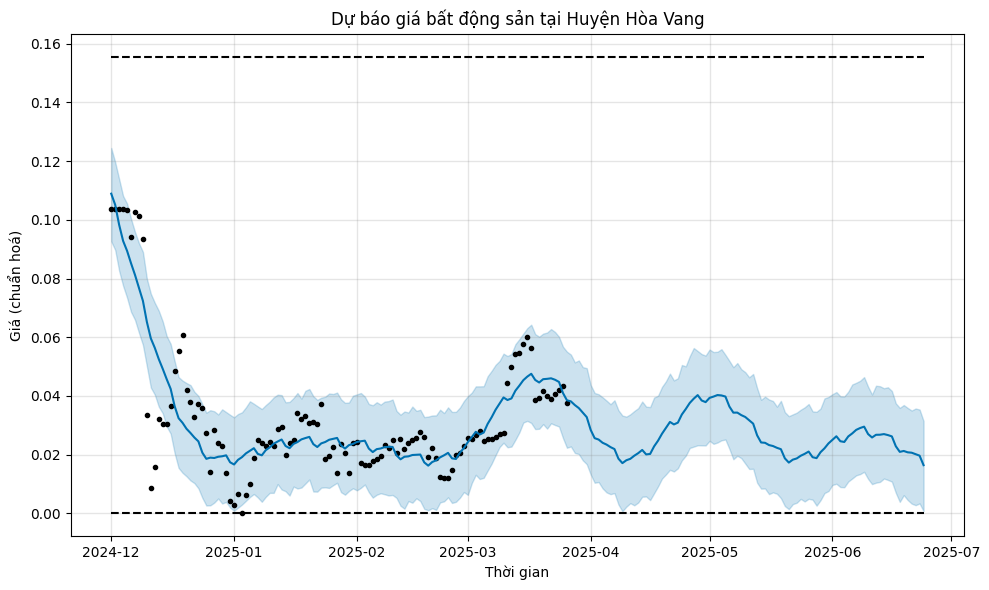

<Figure size 1400x800 with 0 Axes>

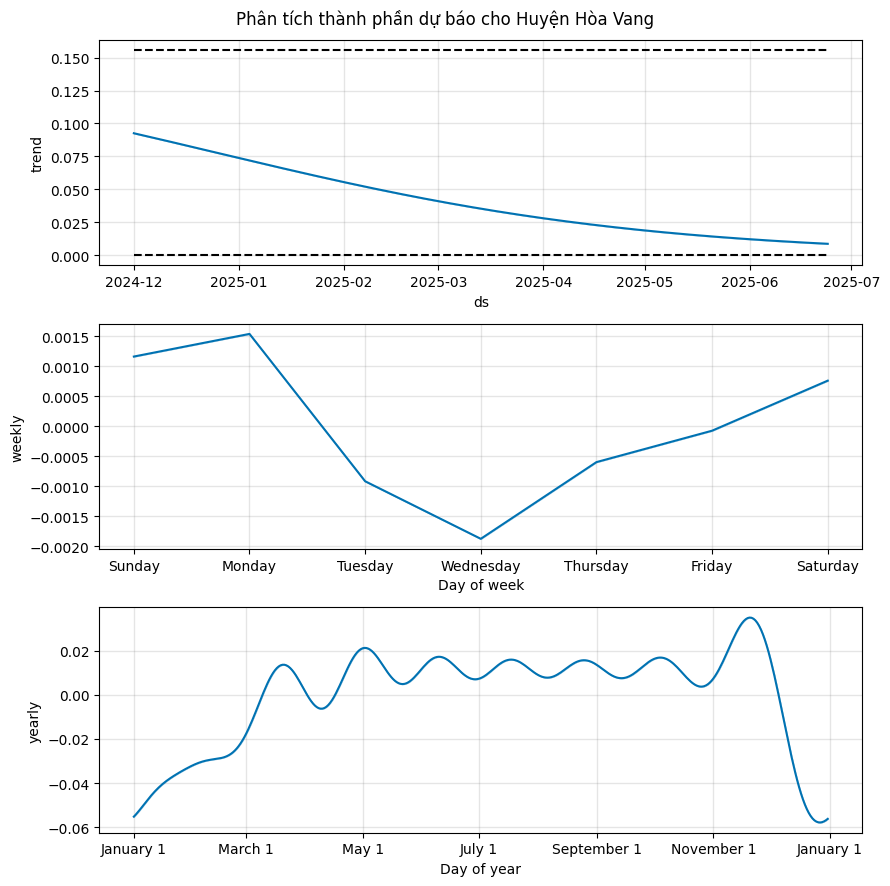

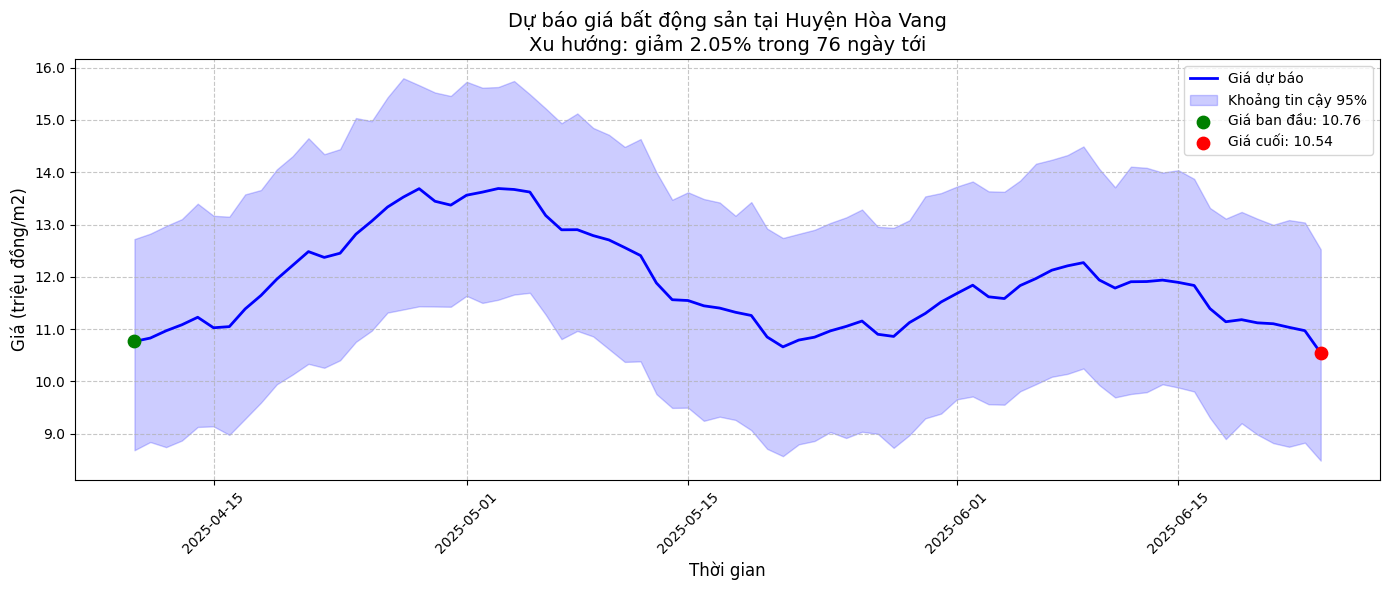


Phân tích xu hướng giá:
• Giá trung bình dự báo: 11.89 triệu đồng/m2
• Giá thấp nhất dự báo: 10.54 triệu đồng/m2
• Giá cao nhất dự báo: 13.69 triệu đồng/m2
• Thay đổi giá trong 90 ngày: -2.05%

🗓 Giá trung bình theo tháng:
• Tháng 2025-04: 12.13 triệu đồng/m2
• Tháng 2025-05: 11.94 triệu đồng/m2
• Tháng 2025-06: 11.62 triệu đồng/m2


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from datetime import datetime, timedelta
from prophet import Prophet

# --- Đọc thông số chuẩn hoá từ file (Min-Max) ---
def load_scaler_params(filepath='predict_scaler_params.csv'):
    df = pd.read_csv(filepath)
    df.set_index('Metric', inplace=True)
    min_val = df.loc['min', 'price']
    max_val = df.loc['max', 'price']
    return min_val, max_val

# --- Nghịch chuẩn hoá (Min-Max) ---
def inverse_scale(value, min_val, max_val):
    return value * (max_val - min_val) + min_val

# --- Hàm dự báo giá bất động sản ---
def forecast_future_prices(district_name, model, periods=90, freq='D', min_val=None, max_val=None):
    # Tạo dataframe cho dự báo tương lai
    future = model.make_future_dataframe(periods=periods, freq=freq)
    
    # Nếu sử dụng logistic growth, thêm cap và floor
    if hasattr(model, 'growth') and model.growth == 'logistic':
        if hasattr(model, 'history') and 'cap' in model.history:
            future['cap'] = model.history['cap'].max()
        else:
            # Nếu không có cap trong history, tạo cap là 1.0 (giá trị chuẩn hóa tối đa)
            future['cap'] = 1.0
        future['floor'] = 0.0    # Đảm bảo không có giá trị âm
    
    # Dự báo
    forecast = model.predict(future)
    
    # Đảm bảo không có giá trị âm (ngay cả khi không dùng logistic growth)
    forecast['yhat'] = forecast['yhat'].clip(lower=0)
    forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
    forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
    
    # Lọc ra các dự báo tương lai
    today = pd.Timestamp(datetime.now().strftime('%Y-%m-%d'))
    future_forecast = forecast[forecast['ds'] >= today].copy()

    # Nghịch chuẩn hoá bằng Min-Max
    if min_val is not None and max_val is not None:
        future_forecast['yhat'] = inverse_scale(future_forecast['yhat'], min_val, max_val)
        future_forecast['yhat_lower'] = inverse_scale(future_forecast['yhat_lower'], min_val, max_val)
        future_forecast['yhat_upper'] = inverse_scale(future_forecast['yhat_upper'], min_val, max_val)

    # Tạo dataframe kết quả
    result_df = pd.DataFrame({
        'Ngày': future_forecast['ds'],
        'Quận': district_name,
        'Giá dự báo (triệu đồng/m2)': future_forecast['yhat'],
        'Giá thấp nhất (triệu đồng/m2)': future_forecast['yhat_lower'],
        'Giá cao nhất (triệu đồng/m2)': future_forecast['yhat_upper']
    })

    return result_df, forecast

# --- Vẽ biểu đồ chuẩn Prophet ---
def plot_forecast(model, forecast, district_name):
    """
    Vẽ biểu đồ dự báo chuẩn của Prophet
    
    Parameters:
    model (Prophet): Mô hình Prophet đã huấn luyện
    forecast (DataFrame): Kết quả dự báo từ model.predict()
    district_name (str): Tên quận/huyện
    """
    plt.figure(figsize=(14, 8))
    fig = model.plot(forecast)
    plt.title(f'Dự báo giá bất động sản tại {district_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá (chuẩn hoá)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Vẽ các thành phần của mô hình
    plt.figure(figsize=(14, 8))
    fig = model.plot_components(forecast)
    plt.suptitle(f'Phân tích thành phần dự báo cho {district_name}')
    plt.tight_layout()
    plt.show()

# --- Vẽ biểu đồ tùy chỉnh (giá thực) ---
def plot_custom_forecast(result_df, district_name):
    """
    Vẽ biểu đồ tùy chỉnh với giá đã nghịch chuẩn hoá
    
    Parameters:
    result_df (DataFrame): DataFrame chứa kết quả dự báo đã nghịch chuẩn hoá
    district_name (str): Tên quận/huyện
    """
    plt.figure(figsize=(14, 6))
    
    # Vẽ đường dự báo chính
    plt.plot(result_df['Ngày'], result_df['Giá dự báo (triệu đồng/m2)'], 
             'b-', linewidth=2, label='Giá dự báo')
    
    # Vẽ khoảng tin cậy
    plt.fill_between(
        result_df['Ngày'],
        result_df['Giá thấp nhất (triệu đồng/m2)'],
        result_df['Giá cao nhất (triệu đồng/m2)'],
        color='blue', alpha=0.2, label='Khoảng tin cậy 95%'
    )
    
    # Đánh dấu giá ban đầu và giá cuối
    first_price = result_df['Giá dự báo (triệu đồng/m2)'].iloc[0]
    last_price = result_df['Giá dự báo (triệu đồng/m2)'].iloc[-1]
    
    plt.scatter(result_df['Ngày'].iloc[0], first_price, color='green', s=80, zorder=5, 
                label=f'Giá ban đầu: {first_price:.2f}')
    plt.scatter(result_df['Ngày'].iloc[-1], last_price, color='red', s=80, zorder=5, 
                label=f'Giá cuối: {last_price:.2f}')
    
    # Tính phần trăm thay đổi
    price_change_pct = ((last_price - first_price) / first_price) * 100
    change_direction = "tăng" if price_change_pct >= 0 else "giảm"
    
    # Tiêu đề và nhãn
    plt.title(f'Dự báo giá bất động sản tại {district_name}\n'
              f'Xu hướng: {change_direction} {abs(price_change_pct):.2f}% trong '
              f'{len(result_df)} ngày tới', fontsize=14)
    plt.xlabel('Thời gian', fontsize=12)
    plt.ylabel('Giá (triệu đồng/m2)', fontsize=12)
    
    # Định dạng trục và lưới
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    
    # Định dạng trục y để hiển thị số tiền
    from matplotlib.ticker import FuncFormatter
    def millions_formatter(x, pos):
        return f'{x:,.1f}'
    plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    
    # Hiển thị chú thích
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

# --- Chương trình chính ---
def main():
    # --- Tải mô hình Prophet ---
    try:
        with open('district_prophet_models.pkl', 'rb') as f:
            district_models = pickle.load(f)
        print("Đã tải mô hình Prophet thành công!")
    except Exception as e:
        print(f"Lỗi khi tải mô hình: {e}")
        return

    # --- Tải scaler Min-Max ---
    try:
        min_val, max_val = load_scaler_params('predict_scaler_params.csv')
        print(f"✅ Tải scaler thành công: min={min_val}, max={max_val}")
    except Exception as e:
        print(f"Lỗi khi tải scaler: {e}")
        return

    # --- Lấy danh sách quận ---
    available_districts = list(district_models.keys())
    print(f"Các quận hiện có trong mô hình: {available_districts}")

    # --- Chọn quận để dự báo ---
    district_name = available_districts[0]  # sửa thành tên quận mong muốn nếu cần
    prophet_model = district_models[district_name]
    periods = 90  # số ngày dự báo

    print(f"\nĐang dự báo giá cho {district_name} trong {periods} ngày tới...")

    # --- Kiểm tra và cập nhật model growth nếu cần ---
    # Lưu ý: Cập nhật này chỉ áp dụng cho lần chạy hiện tại, không làm thay đổi model đã lưu
    if not hasattr(prophet_model, 'growth') or prophet_model.growth != 'logistic':
        print("Đang chuyển mô hình sang logistic growth để tránh dự báo giá âm...")
        # Copy và chuyển đổi model - chỉ áp dụng cho lần dự báo này
        # Trong thực tế, nên huấn luyện lại mô hình với logistic growth
        prophet_model.growth = 'logistic'

    # --- Dự báo ---
    result_df, forecast = forecast_future_prices(
        district_name,
        prophet_model,
        periods=periods,
        min_val=min_val,
        max_val=max_val
    )

    # --- In kết quả ---
    print("\nKết quả dự báo:")
    print(result_df.head(10))

    # --- Xuất CSV ---
    today = datetime.now().strftime('%Y-%m-%d')
    end_date = (datetime.now() + timedelta(days=periods)).strftime('%Y-%m-%d')
    csv_filename = f"{district_name}_prophet_forecast_{today}_to_{end_date}.csv"
    result_df.to_csv(csv_filename, index=False)
    print(f"\nĐã lưu kết quả dự báo vào file: {csv_filename}")

    # --- Vẽ biểu đồ ---
    plot_forecast(prophet_model, forecast, district_name)
    plot_custom_forecast(result_df, district_name)

    # --- Phân tích xu hướng ---
    avg_price = result_df['Giá dự báo (triệu đồng/m2)'].mean()
    min_price = result_df['Giá dự báo (triệu đồng/m2)'].min()
    max_price = result_df['Giá dự báo (triệu đồng/m2)'].max()

    first_price = result_df['Giá dự báo (triệu đồng/m2)'].iloc[0]
    last_price = result_df['Giá dự báo (triệu đồng/m2)'].iloc[-1]
    price_change = ((last_price - first_price) / first_price) * 100

    print("\nPhân tích xu hướng giá:")
    print(f"• Giá trung bình dự báo: {avg_price:,.2f} triệu đồng/m2")
    print(f"• Giá thấp nhất dự báo: {min_price:,.2f} triệu đồng/m2")
    print(f"• Giá cao nhất dự báo: {max_price:,.2f} triệu đồng/m2")
    print(f"• Thay đổi giá trong {periods} ngày: {price_change:.2f}%")

    # --- Trung bình theo tháng ---
    result_df['Tháng'] = result_df['Ngày'].dt.to_period('M')
    monthly_avg = result_df.groupby('Tháng')['Giá dự báo (triệu đồng/m2)'].mean()

    print("\n🗓 Giá trung bình theo tháng:")
    for month, price in monthly_avg.items():
        print(f"• Tháng {month}: {price:,.2f} triệu đồng/m2")

# --- Chạy chương trình ---
if __name__ == "__main__":
    main()